This notebook is a starter workflow for comparing DNA methylation between two biological groups using Illumina 450K methylation arrays. 
We’ll use Bioconductor’s **minfi** for reading IDATs, QC, and normalization, then **limma**/**DMRcate** for differential methylation at CpGs and regions. 
The example dataset is GEO **GSE49667**, a small, high-signal comparison of sorted human naïve CD4+ T cells vs resting regulatory T cells.


Data download
The downloader script below will create a dataset folder with `idats/` and a `targets.csv` file that minfi can read.


In [2]:
## Setup
data_dir <- normalizePath(file.path("data"), mustWork = FALSE)
downloader <- normalizePath(file.path("data", "downloaders", "download_geo_gse47915.R"), mustWork = FALSE)

# ---- Install packages (skip if your environment is already provisioned) ----
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
cran_pkgs <- c("ggplot2", "dplyr", "stringr", "R.utils")
bioc_pkgs <- c(
  "GEOquery",
  "Biobase",
  "minfi",
  "limma",
  "DMRcate",
  "missMethyl",
  "IlluminaHumanMethylation450kmanifest",
  "IlluminaHumanMethylation450kanno.ilmn12.hg19"
)
for (p in cran_pkgs) if (!requireNamespace(p, quietly = TRUE)) install.packages(p)
for (p in bioc_pkgs) if (!requireNamespace(p, quietly = TRUE)) BiocManager::install(p, ask = FALSE, update = FALSE)

# ---- Download if missing ----
source(downloader)
download_if_missing(data_dir, gse = "GSE47915")

# Peek at what was created
list.files(data_dir)


[1] "downloaders"                "geo_gse47915_prostate_450k"

## 2) Load the IDATs into minfi

`targets.csv` contains a `Basename` column pointing to each sample’s IDAT pair (`*_Grn.idat` / `*_Red.idat`).  
We’ll show the table *before* loading, then confirm the phenotype table stored in the resulting `RGChannelSet`.


In [ ]:
library(minfi)
library(dplyr)
library(SummarizedExperiment)
library(S4Vectors)

ds_dir <- file.path(data_dir, "geo_gse47915_prostate_450k")

targets <- read.csv(file.path(ds_dir, "targets.csv"), stringsAsFactors = FALSE)

# Preview (relative basenames only; safe for git)
targets %>%
  select(Sample_Name, Basename) %>%
  head(10)

# Read IDATs
rgSet <- local({
  oldwd <- getwd()
  setwd(ds_dir)
  on.exit(setwd(oldwd), add = TRUE)

  read.metharray.exp(targets = targets, extended = TRUE)
})

# Give samples stable human-readable names
colnames(rgSet) <- make.unique(targets$Sample_Name)

# Store phenotype (SummarizedExperiment-style)
pheno <- targets
rownames(pheno) <- colnames(rgSet)
colData(rgSet) <- DataFrame(pheno)

rgSet
as.data.frame(colData(rgSet)) %>% select(Sample_Name, Basename) %>% head()


,Sample_Name,Basename
,<chr>,<chr>
1,GSM1162363_6264509108_R01C02,idats/GSM1162363_6264509108_R01C02
2,GSM1162364_6264509130_R04C02,idats/GSM1162364_6264509130_R04C02
3,GSM1162365_6264509130_R03C02,idats/GSM1162365_6264509130_R03C02
4,GSM1162369_6264509130_R06C01,idats/GSM1162369_6264509130_R06C01
5,GSM1162375_6264509130_R05C01,idats/GSM1162375_6264509130_R05C01
6,GSM1162380_6285609104_R03C02,idats/GSM1162380_6285609104_R03C02
7,GSM1162381_6285650040_R06C02,idats/GSM1162381_6285650040_R06C02
8,GSM1162382_6285650050_R01C01,idats/GSM1162382_6285650050_R01C01


class: RGChannelSetExtended 
dim: 622399 8 
metadata(0):
assays(5): Green Red GreenSD RedSD NBeads
rownames(622399): 10600313 10600322 ... 74810490 74810492
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(2): Sample_Name Basename
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19

,Sample_Name,Basename
,<chr>,<chr>
GSM1162363_6264509108_R01C02,GSM1162363_6264509108_R01C02,idats/GSM1162363_6264509108_R01C02
GSM1162364_6264509130_R04C02,GSM1162364_6264509130_R04C02,idats/GSM1162364_6264509130_R04C02
GSM1162365_6264509130_R03C02,GSM1162365_6264509130_R03C02,idats/GSM1162365_6264509130_R03C02
GSM1162369_6264509130_R06C01,GSM1162369_6264509130_R06C01,idats/GSM1162369_6264509130_R06C01
GSM1162375_6264509130_R05C01,GSM1162375_6264509130_R05C01,idats/GSM1162375_6264509130_R05C01
GSM1162380_6285609104_R03C02,GSM1162380_6285609104_R03C02,idats/GSM1162380_6285609104_R03C02


## 3) Quality control

The two most common early checks are:
- **Median intensity QC**: samples with unusually low methylated/unmethylated signal are often poor-quality.
- **Detection p-values**: probes with poor signal-to-noise in a sample can be filtered before modeling.


Loading required package: IlluminaHumanMethylation450kmanifest



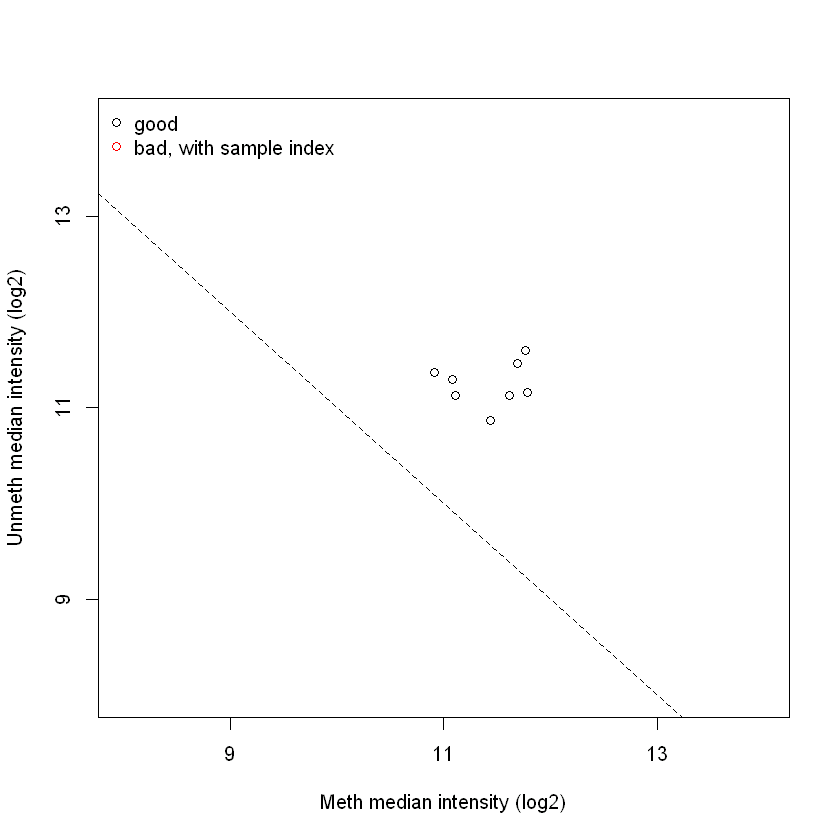

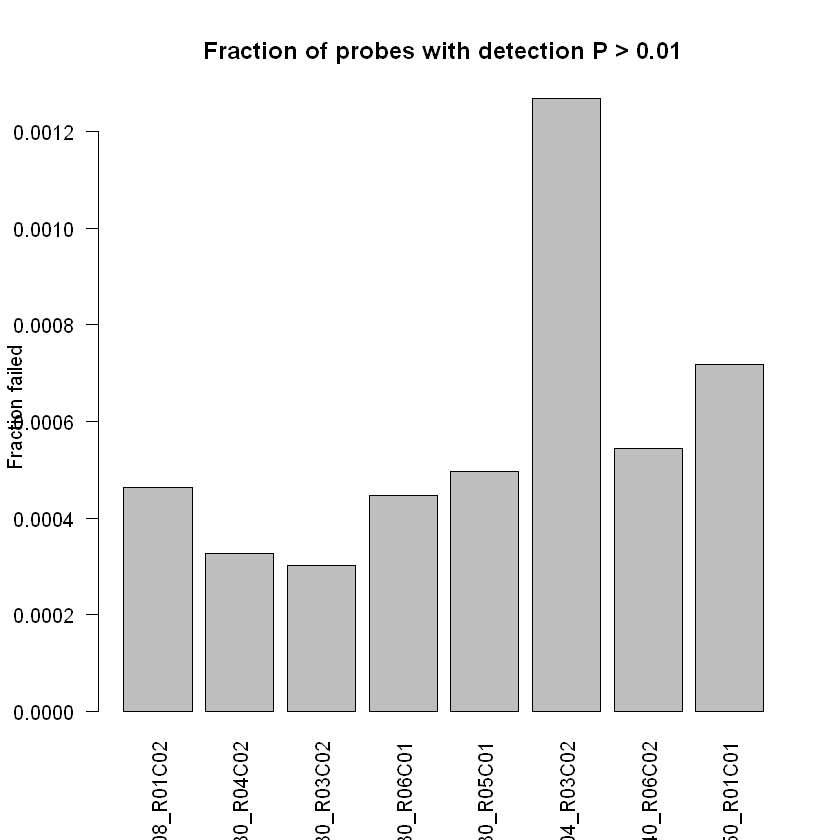

In [4]:
# Basic QC based on raw intensities
mSet_raw <- preprocessRaw(rgSet)

qc <- getQC(mSet_raw)
plotQC(qc)

# Detection p-values (probe-level)
detP <- detectionP(rgSet)

# Fraction of failed probes per sample (detP > 0.01)
frac_failed <- colMeans(detP > 0.01, na.rm = TRUE)
barplot(frac_failed, las = 2, main = "Fraction of probes with detection P > 0.01", ylab = "Fraction failed")
abline(h = 0.01, lty = 2)


## 4) Normalization + quick exploration

We'll use **Noob** background correction (common default for 450K).  
Typical quick-look plots: Beta density (distribution shifts) and MDS/PCA (group separation, batch effects).


In [ ]:
library(ggplot2)

# Noob normalization returns a MethylSet
mSet_noob <- preprocessNoob(rgSet)

# Convert to genome-mapped ratio set for convenient Beta/M access
gSet <- mapToGenome(ratioConvert(mSet_noob, what = "both", keepCN = TRUE))

beta <- getBeta(gSet)
mvals <- getM(gSet)

# Beta density by group (randomly sample probes for speed)
set.seed(1)
idx <- sample(seq_len(nrow(beta)), 10000)
beta_long <- data.frame(
  beta = as.vector(beta[idx, ]),
  sample = rep(colnames(beta), each = length(idx)),
  group = rep(pData(gSet)$Sample_Group, each = length(idx))
)

ggplot(beta_long, aes(x = beta, group = sample)) +
  geom_density(alpha = 0.15) +
  facet_wrap(~group, ncol = 2) +
  labs(title = "Beta-value density per sample (faceted by group)")


In [ ]:
library(limma)

# MDS plot: samples closer together are more similar overall
plotMDS(mvals, labels = pData(gSet)$Sample_Group, col = as.integer(factor(pData(gSet)$Sample_Group)))
legend("topright", legend = levels(factor(pData(gSet)$Sample_Group)),
       col = seq_along(levels(factor(pData(gSet)$Sample_Group))), pch = 16, cex = 0.8)


## 5) Probe filtering

For a starter analysis, we’ll do a lightweight filter: keep probes that pass detection P ≤ 0.01 in at least 90% of samples.

In real projects you’ll usually add filters for cross-reactive probes and probes affected by common SNPs (see “Additional considerations” at the end).


In [ ]:
keep_probes <- rowMeans(detP <= 0.01, na.rm = TRUE) >= 0.90
sum(keep_probes)
gSet_f <- gSet[keep_probes, ]

beta_f <- getBeta(gSet_f)
mvals_f <- getM(gSet_f)


## 6) Differential methylation at CpG sites (DMPs) with limma

We'll compare **naive vs rTreg** (resting regulatory T cells).  
We include **Donor** as a covariate to reduce donor-specific confounding.


In [ ]:
# Subset to the main biological comparison
pheno <- pData(gSet_f)
keep_samples <- pheno$Sample_Group %in% c("naive", "rTreg")
gSet_sub <- gSet_f[, keep_samples]

pheno_sub <- pData(gSet_sub)
pheno_sub$Sample_Group <- factor(pheno_sub$Sample_Group, levels = c("naive", "rTreg"))
pheno_sub$Donor <- factor(pheno_sub$Donor)

m_sub <- getM(gSet_sub)
beta_sub <- getBeta(gSet_sub)

design <- model.matrix(~ 0 + Sample_Group + Donor, data = pheno_sub)
colnames(design) <- make.names(colnames(design))

# Contrast: rTreg - naive
cont <- makeContrasts(Sample_GrouprTreg - Sample_Groupnaive, levels = design)

fit <- lmFit(m_sub, design)
fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2)

dmp <- topTable(fit2, number = Inf, sort.by = "P", adjust.method = "BH")

# Effect size: delta-beta (more interpretable than M-values)
dmp$delta_beta <- rowMeans(beta_sub[, pheno_sub$Sample_Group == "rTreg", drop = FALSE]) -
                  rowMeans(beta_sub[, pheno_sub$Sample_Group == "naive", drop = FALSE])

# Summary
table(dmp$adj.P.Val < 0.05)
head(dmp[, c("logFC", "P.Value", "adj.P.Val", "delta_beta")])


### Volcano-style view

You typically look for CpGs with both strong statistical support and meaningful methylation difference (e.g., |Δβ| ≥ 0.10).


In [ ]:
dmp$neglog10p <- -log10(dmp$P.Value)
dmp$hit <- (dmp$adj.P.Val < 0.05) & (abs(dmp$delta_beta) >= 0.10)

ggplot(dmp, aes(x = delta_beta, y = neglog10p)) +
  geom_point(alpha = 0.35) +
  geom_point(data = subset(dmp, hit), alpha = 0.7) +
  labs(title = "DMPs: rTreg vs naive", x = "Delta Beta (rTreg - naive)", y = "-log10(p-value)")


## 7) Regional differential methylation (DMRs) with DMRcate

DMRs are clusters of nearby CpGs that shift together, which often map more cleanly onto regulatory elements than individual CpGs.


In [ ]:
library(DMRcate)

# DMRcate works well with M-values as input
myAnnotation <- cpg.annotate(
  object = m_sub,
  datatype = "array",
  what = "M",
  analysis.type = "differential",
  design = design,
  contrasts = TRUE,
  cont.matrix = cont,
  coef = colnames(cont)[1],   # must match a cont.matrix column name
  arraytype = "450K"
)

dmrc <- dmrcate(myAnnotation, lambda = 1000, C = 2)
dmrs <- extractRanges(dmrc, genome = "hg19")
dmrs[1:5]


### Visualize the top DMR

`DMR.plot()` shows CpGs in the region, a heatmap of sample beta values, and group means across the region.


In [ ]:
library(DMRcatedata)

# Plot first DMR (if present)
if (length(dmrs) > 0) {
  DMR.plot(
    ranges = dmrs,
    dmr = 1,
    CpGs = beta_sub,
    phen.col = pheno_sub$Sample_Group,
    genome = "hg19"
  )
}


## 8) Gene set enrichment (GO / KEGG) with missMethyl

Gene set testing for methylation arrays is tricky because genes have different numbers of probes on the array.  
`gometh()` adjusts for this probe-number bias (and multi-gene mapping), which makes enrichment results more trustworthy.


In [ ]:
library(missMethyl)

sig_cpg <- rownames(dmp)[dmp$adj.P.Val < 0.05]
all_cpg <- rownames(dmp)

go <- gometh(sig.cpg = sig_cpg, all.cpg = all_cpg, collection = "GO", plot.bias = TRUE)
topGO(go, number = 10)

kegg <- gometh(sig.cpg = sig_cpg, all.cpg = all_cpg, collection = "KEGG")
topKEGG(kegg, number = 10)


## Additional considerations

- **Probe filtering**: in production you’ll usually remove cross-reactive probes, probes with common SNPs at the CpG or single-base extension, and (depending on your design) sex chromosome probes.
- **Normalization choice**: Noob is a good default; functional normalization (`preprocessFunnorm`) can be better when strong technical variation is present, especially in blood datasets with diverse cell mixes.
- **Batch effects**: if you have slide/plate/run information, include it in the design matrix (or use `duplicateCorrelation` / mixed models).
- **Cell composition**: for whole blood or tissues, estimate and adjust cell proportions (e.g., `estimateCellCounts`)—but for sorted cells like this dataset it’s less relevant.


## Typical follow-ups

- Plot methylation across *specific loci* of interest (e.g., FOXP3 enhancers) and link to expression if available.
- Run **epigenetic age** / clock estimates if the design includes age-related questions.
- Integrate with ATAC-seq/ChIP-seq to interpret DMRs in regulatory context.


In [ ]:
sessionInfo()
